# (4) Analysing multiple athletes

I can now use my modules to analyse the data from multiple athletes/sensors.

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
sns.set_context('notebook')

In [5]:
import numpy as np

In [6]:
from time import sleep

In [7]:
from Queue import Queue

In [8]:
from streamanalysis import Athlete, Sensor, Analyser

## Data generation

I first initialize 20 athletes and an empty queue. I keep all athletes in a list. All sensors simply submit their data to the same queue, where they can be distinguished by the sensor ID.

In [9]:
N = 20
athlete_list = []
for i in range(N):
    athlete = Athlete(keepdata=True)
    athlete_list.append(athlete)
q = Queue()

I now create a sensor for each athlete. Again, I keep all sensors in a list. I simply use the index of the list-element as sensor ID.

In [10]:
sensor_list = []
for i, athlete in enumerate(athlete_list):
    sensor_list.append(Sensor(athlete, q, ID = str(i)))

Now I start all the sensors and one additional analysis thread that analyses the data from the queue. Finally, I test if the analyser was able to process all the data in real time. Because it stops after waiting for 1 second, I simply test if the `analyser` process stopped 1.1 second after I stopped the sensors.

In [11]:
analyser = Analyser(q)
[athlete.reset() for athlete in athlete_list]
[sensor.start() for sensor in sensor_list]
analyser.start()
runtime = 60 * 5
sleep(runtime)
[sensor.stop() for sensor in sensor_list]
sleep(1.1)
print analyser.isAlive()

False


## Analyse results

I first recover the results for each sensor from the dictionary at `analyser.sensors`. I also get the true positions and velocities from the athlete instances.

In [12]:
results_list = []
true_list = []
for i, athlete in enumerate(athlete_list):
    results_list.append(analyser.sensors[str(i)])
    true_list.append(athlete.data)

In [13]:
ellapsed = []
for r in results_list:
    nr = len(r)
    delta_time = []
    for i in range(nr-1):
        dt = r[i+1].time-r[i].time
        delta_time.append(dt.total_seconds())
    ellapsed.append(np.append(0,np.cumsum(delta_time))/60.)

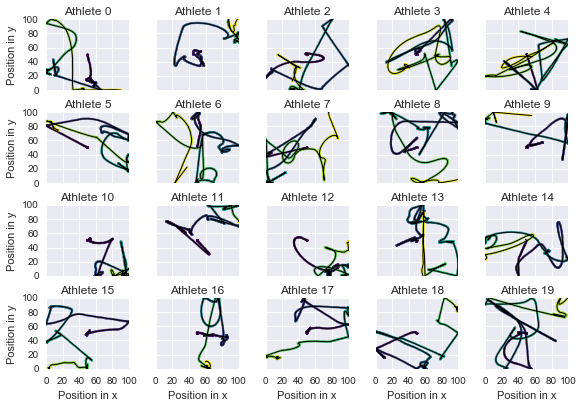

In [14]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True)
plt.tight_layout()
for i, (t, r) in enumerate(zip(true_list, results_list)):
    ax = axs.ravel()[i]
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    t_pos = np.asarray(t)[:,0]
    r_pos = np.asarray([r_.pos for r_ in r])
    ax.scatter(r_pos[:,0], r_pos[:,1], c = ellapsed[i], alpha = .3, cmap = 'viridis',
               edgecolors='none', label = 'Filtered measurements', marker = '.')
    ax.plot(t_pos[:,0],t_pos[:,1],color='k',linewidth=1.)
    ax.set_title('Athlete %i'%i)
for ax in axs[:,0]:
    ax.set_ylabel('Position in y')
for ax in axs[-1]:
    ax.set_xlabel('Position in x')

Each panel of the plot show the true trajectory of one of the athletes over 5 minutes together with the position estimated with the Kalman Filter. It shows that the algorithm nicely separates the workload on the queue from the different sensors and makes the results available through the dictionary at `analyser.sensors`.

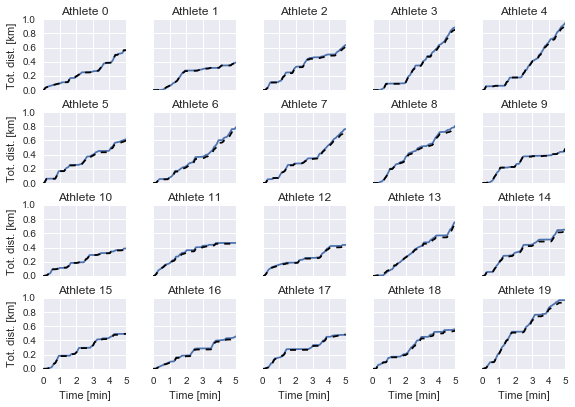

In [15]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True)
plt.tight_layout()
for i, (t, r) in enumerate(zip(true_list, results_list)):
    ax = axs.ravel()[i]
    ax.set_xlim(0,5)
    ax.set_ylim(0,1.0)
    t_pos = np.asarray(t)[:,0]
    t_ = np.sqrt(((t_pos[1:]-t_pos[:-1]) * (t_pos[1:]-t_pos[:-1])).sum(axis = 1))
    t_dist = np.append(0,np.cumsum(t_))/1000.
    r_dist = np.asarray([r_.dist for r_ in r])/1000.
    ax.plot(ellapsed[i],r_dist)
    ax.plot(ellapsed[i],t_dist,color='k',linestyle = '--')
    ax.set_title('Athlete %i'%i)
for ax in axs[:,0]:
    ax.set_ylabel('Tot. dist. [km]')
for ax in axs[-1]:
    ax.set_xlabel('Time [min]')

This plot shows the comparison of the true total distance covered (black dashed) and the total distance covered estimated from the filtered position data (blue). As before, the algorithm slightly overpredicts the distance but shows good agreement overall.

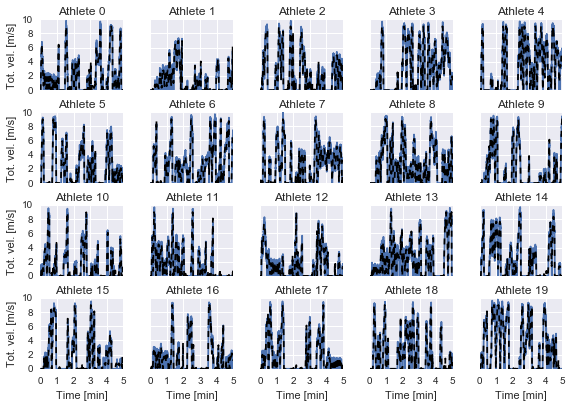

In [18]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=True)
plt.tight_layout()
for i, (t, r) in enumerate(zip(true_list, results_list)):
    ax = axs.ravel()[i]
    ax.set_xlim(0,5)
    ax.set_ylim(0,10.0)
    tv_ = np.asarray(t)[:,1]
    true_tot_vel = np.sqrt((tv_*tv_).sum(axis = 1))
    tot_vel = np.asarray([r_.tot_vel for r_ in r])
    ax.plot(ellapsed[i],tot_vel)
    ax.plot(ellapsed[i],true_tot_vel,color='k',linestyle = '--')
    ax.set_title('Athlete %i'%i)
for ax in axs[:,0]:
    ax.set_ylabel('Tot. vel. [m/s]')
for ax in axs[-1]:
    ax.set_xlabel('Time [min]')

This plot shows the comparison of the true total velocity (black dashed) and the total velocity estimated from the x- and y-component of the filtered velocity data (blue). As before, the total velocity is overpredicted at small total velocities and I simply set it to zero as long as the velocity-vector is consistent with a stationary athlete.